In [41]:
path_ICON = "/home/jvillarreal/Documents/phd/dataset/data_rttov_T12.nc"
path_output = "/home/jvillarreal/Documents/phd/output/ML_output"
path_OUTPUT_RTTOV = "/home/jvillarreal/Documents/phd/github/output-rttov/output-test-2-modis.nc"
rttov_path_refl_emmis = "/home/jvillarreal/Documents/phd/github/output-rttov/rttov-131-data-icon-1to19-26-T12.nc"
rttov_path_rad = "/home/jvillarreal/Documents/phd/github/output-rttov/rttov-13-data-icon-1-to-36-not-flip.nc"
path_rttov_test = "/home/jvillarreal/Documents/phd/github/output-rttov/rttov-131-data-icon-1to36-T09.nc"
path_ICON_test = "/home/jvillarreal/Documents/phd/dataset/data_rttov_T09.nc"
path_ICON_test_2 = "/work/bb1036/b381362/dataset/data_rttov_T15.nc"



In [5]:
import xarray as xr
from scipy.special import gamma
import numpy as np
# ds = xr.open_dataset("/work/bb1036/b381362/dataset/data_rttov_T12.nc")
ds = xr.open_dataset("/home/jvillarreal/Documents/phd/dataset/data_rttov_T12.nc")


ds

<xarray.Dataset>
Dimensions:       (lat: 637, lon: 589, height: 150)
Coordinates:
  * height        (height) float64 1.0 2.0 3.0 4.0 ... 147.0 148.0 149.0 150.0
  * lat           (lat) float64 47.5 47.51 47.52 47.53 ... 54.47 54.48 54.5
  * lon           (lon) float64 4.5 4.517 4.534 4.551 ... 14.45 14.46 14.48 14.5
Data variables: (12/21)
    FR_LAND       (lat, lon) float32 ...
    cct           (lat, lon) float32 ...
    clc           (height, lat, lon) float32 ...
    cli           (height, lat, lon) float32 ...
    clw           (height, lat, lon) float32 ...
    clwvi         (lat, lon) float32 ...
    ...            ...
    tas           (lat, lon) float32 ...
    topography_c  (lat, lon) float32 ...
    u_10m         (lat, lon) float32 ...
    v_10m         (lat, lon) float32 ...
    z_ifc         (height, lat, lon) float32 ...
    z_mc          (height, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.4
    uuidOfVGrid:  3be5ac35-92f4-4e91-7418-b62336222e20
    title:        ICON simulation
    history:      Wed Apr  6 16:27:59 2022: ncks -C -O -x -v height_bnds /wor...
    references:   see MPIM/DWD publications
    comment:      HDCP2 Sammelaccount (k203095) on m21726 (Linux 2.6.32-696.1...
    NCO:          netCDF Operators version 5.0.1 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [6]:
T_c =  np.float64(ds.ta) - 273.15
esat_2013 = 0.611* np.exp((17.3*T_c)/(T_c+237.3))*1000.0
#esat_2013 = np.ma.masked_array(esat_2013,  esat_2013 == 0) ## check it!!!!!!!!
pres = np.ma.masked_array(ds.pres,  ds.pres == 0) ## check it!!!!!!!!
qs_2013 =  0.622* (esat_2013/pres)
r_2013 = ds.hus/(1 - ds.hus)
RH_2013 = 100*(r_2013/qs_2013)
pv_2013 = (esat_2013 * RH_2013)/100.0
pd_2013 = ds.pres - pv_2013
rho_2013 = (pd_2013/(287.058 * ds.ta)) + (pv_2013/(461.495 * ds.ta))  #nana
cdnc_2013_cm = (rho_2013 * ds.qnc)/1000000 # convert to cm^-3


ds = ds.assign(lwp = ds.clwvi*1000)
ds.lwp.attrs['units'] = "gm-2"
ds.lwp.attrs['standard_name'] = "LWP"
ds.lwp.attrs['long_name'] = "Liquid water path"

Nd_max = np.nanmax(cdnc_2013_cm, axis = 0)
ds["Nd_max"]=(['lat', 'lon'],  Nd_max) #this is an array
ds.Nd_max.attrs['units'] = "cm-3"
ds.Nd_max.attrs['standard_name'] = "Nd_max"
ds.Nd_max.attrs['long_name'] = "Cloud dropler number maximun"

ds["Nd"] =  cdnc_2013_cm #thi is a xarray.DataArray
ds.Nd.attrs['units'] = "cm-3"
ds.Nd.attrs['standard_name'] = "Nd"
ds.Nd.attrs['long_name'] = "Cloud dropler number in each layer"


#-----------------Calculation of the Reff -------------------------
L  = rho_2013*ds.clw # in kgm^-3
N = rho_2013*ds.qnc # im m^-3
# L.where(L == 0, np.Nan, L)
# N.where(N < 2.0e+06, np.Nan, N) !! ask DIPU
######constant for size distribution #############
nu = 1.0
mu = 1.0
a = 1.24E-01
b = 1/3

###################################
reff_2013 = (a/2) * (gamma((3*b+nu+1)/(mu))/gamma((2*b+nu+1)/(mu)))*((L/N)*(gamma((nu+1)/(mu))/gamma((nu+2)/mu)))**(b)
reff_2013 = reff_2013*1E6

ds["Reff"] =  reff_2013 #thi is a xarray.DataArray
ds.Reff.attrs['units'] = "Micron"
ds.Reff.attrs['standard_name'] = "Reff"
ds.Reff.attrs['long_name'] = "Cloud effective radius"



ds.to_netcdf('/home/jvillarreal/Documents/phd/dataset/data_rttov_T12_reff.nc') 

print("next values only work with data_rttov_12")
print('===============T_2013 (height 120, lat 57, lon 227) cm: 276.151153564453 == ', ds.ta[119, 56, 226])
print('===============T_c (height 120, lat 57, lon 227) cm: 3.00115356445315== ', T_c[119, 56, 226])
print('===============esat_2013 (height 120, lat 57, lon 227) 758.360598313415 == ', esat_2013[119, 56, 226]) #3 mmmmm no sale igual
print('===============p_2013 (height 120, lat 57, lon 227)75935.328125 == ', ds.pres[119, 56, 226]) 
print('===============qs_2013 (height 120, lat 57, lon 227) 0.00621186875461262  == ', qs_2013[119, 56, 226]) #3 mmmmm no sale igual
print('===============r_2013 (height 120, lat 57, lon 227) 0.0062973626597643 == ', r_2013[119, 56, 226])
print('===============RH_2013 (height 120, lat 57, lon 227) 101.376299283339 == ', RH_2013[119, 56, 226])
print('===============pv_2013 (height 120, lat 57, lon 227) 768.797909793127 == ', pv_2013[119, 56, 226])
print('===============pd_2013 (height 120, lat 57, lon 227) 75166.5302152069 == ', pd_2013[119, 56, 226])
print('===============rho_2013 (height 120, lat 57, lon 227) 0.954250058491486 == ', rho_2013[119, 56, 226]) #3 mmmmm no sale igual
print('===============cdnc_2013_cm (height 120, lat 57, lon 227) 15.5508091629487 == ', cdnc_2013_cm[119, 56, 226])
print('===============Reff (height 120, lat 57, lon 227) 17.20 um == ', reff_2013[119, 56, 226])


<ipython-input-6-69d0720e97ec>:19: RuntimeWarning: All-NaN axis encountered
  Nd_max = np.nanmax(cdnc_2013_cm, axis = 0)


next values only work with data_rttov_12
===============T_2013 (height 120, lat 57, lon 227) cm: 276.151153564453 ==  <xarray.DataArray 'ta' ()>
array(276.15115, dtype=float32)
Coordinates:
    height   float64 120.0
    lat      float64 48.12
    lon      float64 8.342
Attributes:
    standard_name:  air_temperature
    long_name:      Temperature
    units:          K
    param:          0.0.0
    cell_methods:   time: mean
    institution:    MPIMET
===============T_c (height 120, lat 57, lon 227) cm: 3.00115356445315==  3.0011535644531477
===============esat_2013 (height 120, lat 57, lon 227) 758.360598313415 ==  758.3605983134149
===============p_2013 (height 120, lat 57, lon 227)75935.328125 ==  <xarray.DataArray 'pres' ()>
array(75935.33, dtype=float32)
Coordinates:
    height   float64 120.0
    lat      float64 48.12
    lon      float64 8.342
Attributes:
    standard_name:  air_pressure
    long_name:      Pressure
    units:          Pa
    param:          0.3.0
    cell_met

In [ ]:
ds.close()

In [3]:
#https://geohackweek.github.io/nDarrays/09-masking/ masking array

In [16]:
#https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dictionary-like-methods

<xarray.Dataset>
Dimensions:       (lat: 637, lon: 589, height: 150)
Coordinates:
  * height        (height) float64 1.0 2.0 3.0 4.0 ... 147.0 148.0 149.0 150.0
  * lat           (lat) float64 47.5 47.51 47.52 47.53 ... 54.47 54.48 54.5
  * lon           (lon) float64 4.5 4.517 4.534 4.551 ... 14.45 14.46 14.48 14.5
Data variables: (12/21)
    FR_LAND       (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    cct           (lat, lon) float32 0.0 0.0 0.0 0.0 ... -999.0 7.681e+04 0.0
    clc           (height, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cli           (height, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clw           (height, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clwvi         (lat, lon) float32 0.0 8.124e-06 8.124e-06 ... 0.01018 0.04625
    ...            ...
    tas           (lat, lon) float32 289.8 289.9 289.9 ... 279.3 279.4 279.3
    topography_c  (lat, lon) float32 411.2 411.7 411.7 393.6 ... 0.0 0.0 0.

/home/jvillarreal/Documents/phd/github/ICON_RTTOV/code_test/lwp_nd.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, z, cmap ='jet', vmin=vmin, vmax = vmax ) #cmap=cmap.N, norm=norm)


===============T_2013 (height 120, lat 57, lon 227) cm: 276.151153564453 ==  276.40933
===============T_c (height 120, lat 57, lon 227) cm: 3.00115356445315==  3.2593384
===============esat_2013 (height 120, lat 57, lon 227) 758.360598313415 ==  772.3939
===============p_2013 (height 120, lat 57, lon 227)75935.328125 ==  76403.13
===============qs_2013 (height 120, lat 57, lon 227) 0.00621186875461262  ==  0.00628808
===============r_2013 (height 120, lat 57, lon 227) 0.0062973626597643 ==  0.004533605
===============RH_2013 (height 120, lat 57, lon 227) 101.376299283339 ==  72.098404
===============pv_2013 (height 120, lat 57, lon 227) 768.797909793127 ==  556.88367
===============pd_2013 (height 120, lat 57, lon 227) 75166.5302152069 ==  75846.25
===============rho_2013 (height 120, lat 57, lon 227) 0.954250058491486 ==  0.960264
===============cdnc_2013_cm (height 120, lat 57, lon 227) 15.5508091629487 ==  0.0


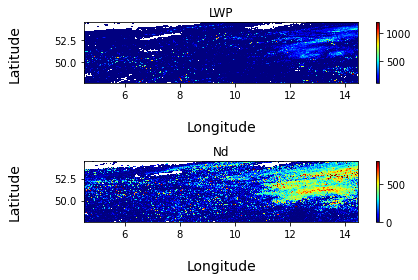

In [1]:

from lwp_nd import lwp_nd_input_ICON

path_ICON = "/home/jvillarreal/Documents/phd/dataset/data_rttov_T12.nc"
path_output = "/home/jvillarreal/Documents/phd/output/input_icon"
ds,p_2013, T_2013, q_2013, max_cdnc_2013_cm, lwp_2013, lat, lon, height = lwp_nd_input_ICON(path_output = path_output,  path_ICON = path_ICON)


In [1]:
import xarray as xr
ds = xr.open_dataset("/home/jvillarreal/Documents/phd/dataset/data_rttov_T12_Reff.nc")

In [2]:

print("next values only work with data_rttov_12")
print('===============T_2013 (height 120, lat 57, lon 227) cm: 276.151153564453 == ', ds.ta[119, 56, 226])
print('===============p_2013 (height 120, lat 57, lon 227)75935.328125 == ', ds.pres[119, 56, 226]) 
print('===============cdnc_2013_cm (height 120, lat 57, lon 227) 15.5508091629487 == ', ds.Nd[119, 56, 226])
print('===============Reff (height 120, lat 57, lon 227) 17.20 um == ', ds.Reff[119, 56, 226])


next values only work with data_rttov_12
===============T_2013 (height 120, lat 57, lon 227) cm: 276.151153564453 ==  <xarray.DataArray 'ta' ()>
array(276.15115, dtype=float32)
Coordinates:
    height   float64 120.0
    lat      float64 48.12
    lon      float64 8.342
Attributes:
    standard_name:  air_temperature
    long_name:      Temperature
    units:          K
    param:          0.0.0
    cell_methods:   time: mean
    institution:    MPIMET
===============p_2013 (height 120, lat 57, lon 227)75935.328125 ==  <xarray.DataArray 'pres' ()>
array(75935.33, dtype=float32)
Coordinates:
    height   float64 120.0
    lat      float64 48.12
    lon      float64 8.342
Attributes:
    standard_name:  air_pressure
    long_name:      Pressure
    units:          Pa
    param:          0.3.0
    cell_methods:   time: mean
    institution:    MPIMET
===============cdnc_2013_cm (height 120, lat 57, lon 227) 15.5508091629487 ==  <xarray.DataArray 'Nd' ()>
array(15.550809)
Coordinates:
    

In [3]:
print('===============Reff (height 120, lat 57, lon 227) 17.20 um == ', ds.Reff[119, 56, 226])


===============Reff (height 120, lat 57, lon 227) 17.20 um ==  <xarray.DataArray 'Reff' ()>
array(17.202336)
Coordinates:
    height   float64 120.0
    lat      float64 48.12
    lon      float64 8.342
Attributes:
    units:          Micron
    standard_name:  Reff
    long_name:      Cloud effective radius


In [8]:
import numpy as np
np.max(ds.Reff[9:,:])

<xarray.DataArray 'Reff' ()>
array(inf)

In [9]:
ds.Reff.min(), ds.Reff.max()

(<xarray.DataArray 'Reff' ()>
 array(0.),
 <xarray.DataArray 'Reff' ()>
 array(inf))

In [18]:
arr = ds.Reff[:,:]

In [20]:
arr

<xarray.DataArray 'Reff' (height: 150, lat: 637, lon: 589)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 147.0 148.0 149.0 150.0
  * lat      (lat) float64 47.5 47.51 47.52 47.53 ... 54.46 54.47 54.48 54.5
  * lon      (lon) float64 4.5 4.517 4.534 4.551 ... 14.45 14.46 14.48 14.5
Attributes:
    units:          Micron
    standard_name:  Reff
    long_name:      Cloud effective radius

In [13]:
import pandas as pd
df_1d = pd.DataFrame({  #falta normalizar
        "Reff" : ds["Reff"].values[:,:].flatten()}) 

In [24]:
np.max(np.nanmax(ds.Reff.values, axis = 0))


<ipython-input-24-847ef9aaf498>:1: RuntimeWarning: All-NaN slice encountered
  np.max(np.nanmax(ds.Reff.values, axis = 0))


nan

In [14]:
df_1d.describe()


,Reff
count,2.486024e+06
mean,inf
std,NaN
min,0.000000e+00
25%,4.212784e+00
50%,7.867323e+00
75%,1.915845e+01
max,inf


===============T_2013 (height 120, lat 57, lon 227) cm: 276.151153564453 ==  <xarray.DataArray 'ta' ()>
array(276.15115, dtype=float32)
Coordinates:
    height   float64 120.0
    lat      float64 48.12
    lon      float64 8.342
Attributes:
    standard_name:  air_temperature
    long_name:      Temperature
    units:          K
    param:          0.0.0
    cell_methods:   time: mean
    institution:    MPIMET


NameError: name 'T_c' is not defined

In [ ]:
#x = lon
#y = lat
x,y = np.meshgrid(lon,lat)
z = variable

levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
# cmap = plt.colormaps['PiYG']
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)


im = ax.pcolormesh(x, y, z, cmap ='jet', vmin=vmin, vmax = vmax ) #cmap=cmap.N, norm=norm)
fig.colorbar(im, ax=ax)
ax.set_title(title_plot)

# ax.set_title("{}{}".format(title_subplot, band),fontsize=14)
ax.set_xlabel('Longitude', labelpad=20,fontsize=14)
ax.set_ylabel('Latitude', labelpad=33,fontsize=14)

    
    

In [ ]:
df = df.fillna(0) 

In [ ]:
lwp.plot()

In [ ]:
lwp.where(lwp != 0, x, NAN)

In [ ]:
max_cdnc_2013_cm = np.ma.masked_array(max_cdnc_2013_cm,  max_cdnc_2013_cm == 0) ## check it!!!!!!!!
lwp_2013 = np.ma.masked_array(lwp_2013,  lwp_2013 == 0) ## check it!!!!!!!!


In [ ]:
!ls /work/bb1036/b381362/dataset

In [ ]:
!ncdump -h /work/bb1036/b381362/dataset/data_rttov_T15.nc

In [ ]:
import xarray as xr
from lwp_nd import lwp_nd_input_ICON


In [ ]:
ds = xr.open_dataset(path_ICON_test_2).compute()


print(ds)           #heightxlatxlon  HxW
lwp_2013_a = ds['clwvi'].values[9:,:] #kg m**-2     #thereare nand en la parte baje check why 2d los demas 3D
lwp_2013 = lwp_2013_a*1000 # g/m^2 Liquid water path
qnc_2013 = ds['qnc'].values[:,9:,:] #kg-1    
T_2013 = ds['ta'].values[:,9:,:]     #testtt dataaa!! instead of values
q_2013 = ds['hus'].values[:,9:,:]   
p_2013  = ds['pres'].values[:,9:,:]    
clw_2013 = ds['clw'].values[:,9:,:]     #kg/kg[:,9:,:]
cli_2013 = ds['cli'].values[:,9:,:]     #kg/kg[:,9:,:]
t_s = ds['t_s'].values[9:,:]
topography = ds['topography_c'].values[9:,:]

lat = ds['lat'].values[9:,]
lon = ds['lon'].values[:]
height = ds['height'].values[:]

####convert cdnc in m^-3####################
T_c =  T_2013 - 273.15

esat_2013 = (0.611* np.exp(17.3*T_c))/(T_c+237.3)
#esat_2013 = np.ma.masked_array(esat_2013,  esat_2013 == 0) ## check it!!!!!!!!
esat_2013 = esat_2013*1000.0
qs_2013 =  0.622* (esat_2013/p_2013)
r_2013 = q_2013/(1-q_2013)
RH_2013 = 100*(r_2013/qs_2013)
pv_2013 = (esat_2013*RH_2013)/100.0
pd_2013 = p_2013 - pv_2013
rho_2013 = (pd_2013/(287.058*T_2013)) + (pv_2013/(461.495*T_2013))  #nana
cdnc_2013_cm = (rho_2013*qnc_2013)/1000000 # convert to cm^-3


#N = rho_2013*qnc_2013 # im m^-3
#L  = rho_2013*clw_2013 # in kgm^-3

dm  = np.shape(qnc_2013) # no se considera time
#dm1 <- dm[1]
#dm=ds.dims
# dm1 = dm[0]
# dm2 = dm[1]
# dm3 = dm[2] 
# select the maximun value

#     cdnc_2013_cm = np.ma.masked_array(cdnc_2013_cm,np.isnan(cdnc_2013_cm))
#     lwp_2013 = np.ma.masked_array(lwp_2013,np.isnan(lwp_2013))

print('max and min cdnc', np.max(cdnc_2013_cm), np.min(cdnc_2013_cm))
max_cdnc_2013_cm = np.nanmax(cdnc_2013_cm, axis = 0)

max_cdnc_2013_cm = np.ma.masked_array(max_cdnc_2013_cm,  max_cdnc_2013_cm == 0) ## check it!!!!!!!!
lwp_2013 = np.ma.masked_array(lwp_2013,  lwp_2013 == 0) ## check it!!!!!!!!

i= 200
j= 50
print('1',np.shape(cdnc_2013_cm),np.shape(max_cdnc_2013_cm), np.shape(lwp_2013))
print('2', np.shape(cdnc_2013_cm.flatten()),np.shape(max_cdnc_2013_cm.flatten()),  np.shape(lwp_2013.flatten()))
print(np.max(cdnc_2013_cm[:,i,j]),'debe ser igual to', max_cdnc_2013_cm[i,j])
print('------------\n', cdnc_2013_cm[:,i,j])



In [ ]:
ds["ta"].values.min(), ds["ta"].values.max()

In [ ]:
ds["hus"].values.min(), ds["hus"].values.max()

In [ ]:
ds["pres"].values.min(),ds["pres"].values.max()

In [ ]:
ds["clwvi"].values.min(),ds["clwvi"].values.max()